🔍 Verificando disponibilidad de GPU...
✅ GPU disponible: NVIDIA GeForce RTX 4070
   Memoria total: 11.59 GB
   Versión CUDA: 12.8
Original CSV Columns: ['live_selfie', 'live_video', 'cut-out_printouts', 'printouts', 'replay']

Reshaped DataFrame (before processing):
Could not open video file: anti-spoofing/replay/0001ffba3c--628c9dbb2579312f1ac7ee6f__С‚РҐРё+РЅС‚РҐРёС‚Р¦РЎС‚РҐРёС‚РҐР­С‚РҐРґ+-С‚РҐРґ+РІС‚РҐРёС‚РҐР¬С‚РҐРёС‚Р¤Р’  С‚РҐРё+Р™20__С‚РҐРё+РЅС‚РҐРёС‚Р¦РЎС‚РҐРёС‚РҐР­С‚РҐРґ+-С‚РҐРґ+РІС‚РҐРёС‚РҐР¬С‚РҐРёС‚Р¤Р’ С‚РҐРёС‚Р¦РЎ22.mp4
Number of extracted frames: 1128

DataFrame with extracted frames:
Total number of entries in final DataFrame: 1137

Final DataFrame:

🎨 Configurando Data Augmentation...
✅ Augmentations configurados:
   - Rotación: ±45°
   - Perspectiva: 30%
   - Crop aleatorio: 70-100%
   - Flip horizontal: 50%
   - Color jitter: brightness/contrast/sat/hue
   - Gaussian blur
Number of entries after filtering long paths: 1137

📊 Configuración de entrenamiento:
   Dispositivo

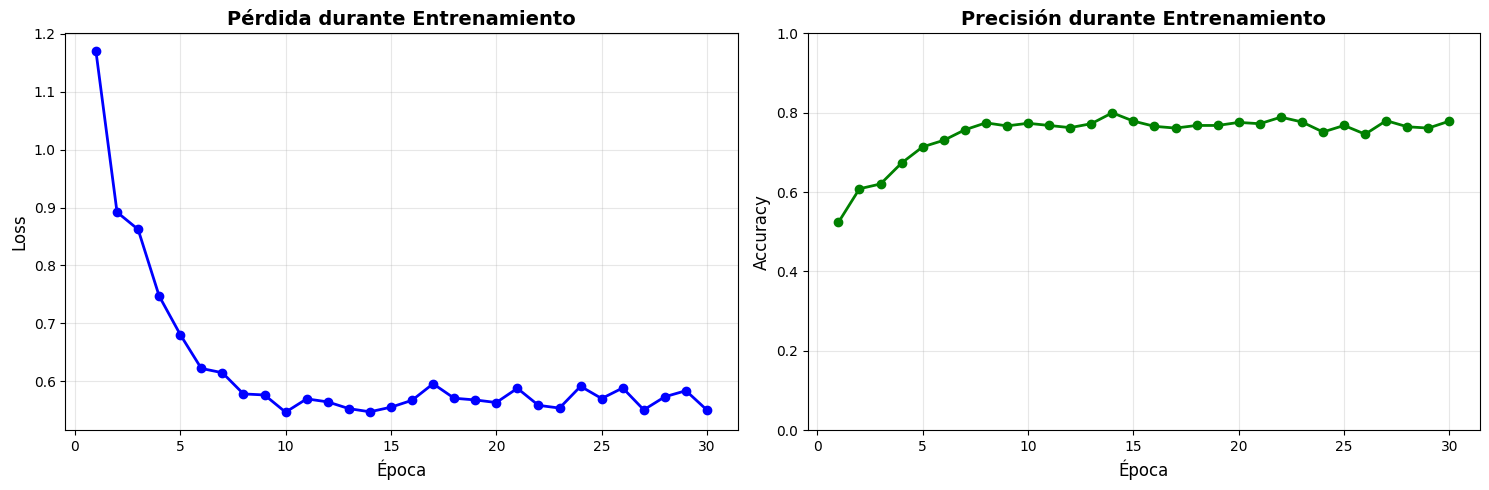

✅ Gráfica de curvas de entrenamiento guardada


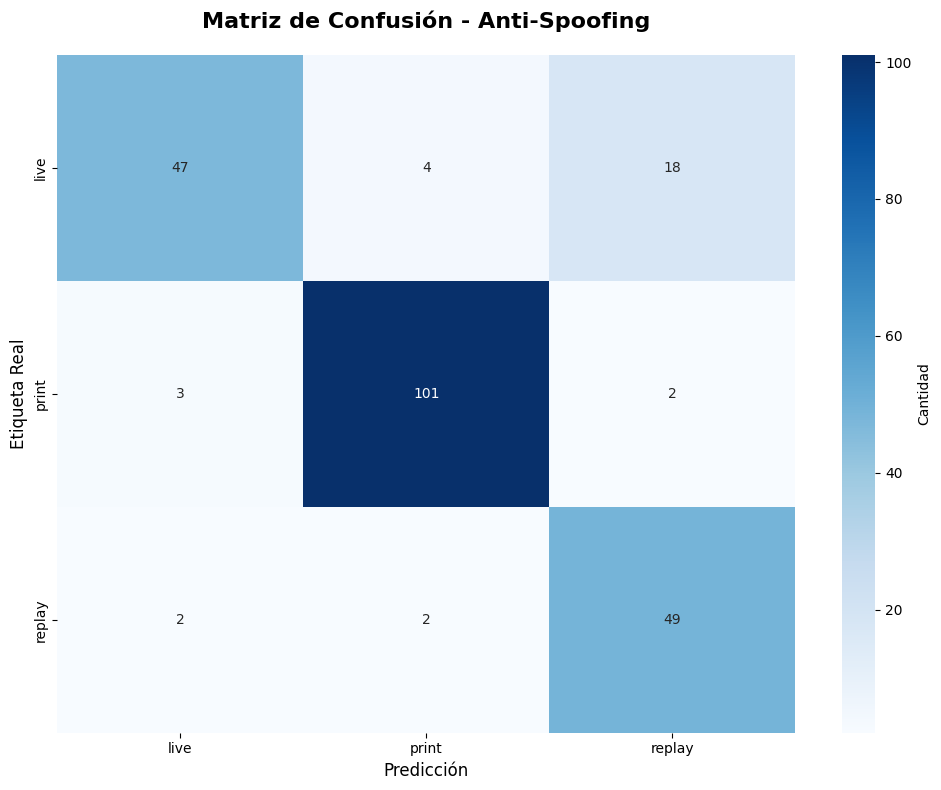

✅ Matriz de confusión guardada


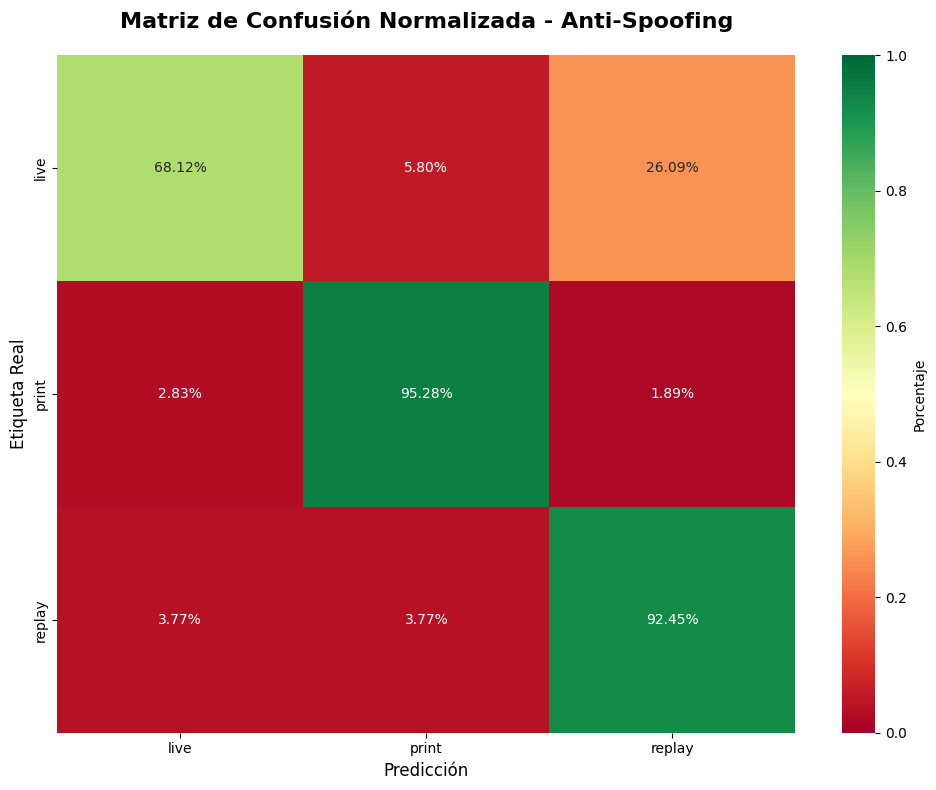

✅ Matriz de confusión normalizada guardada


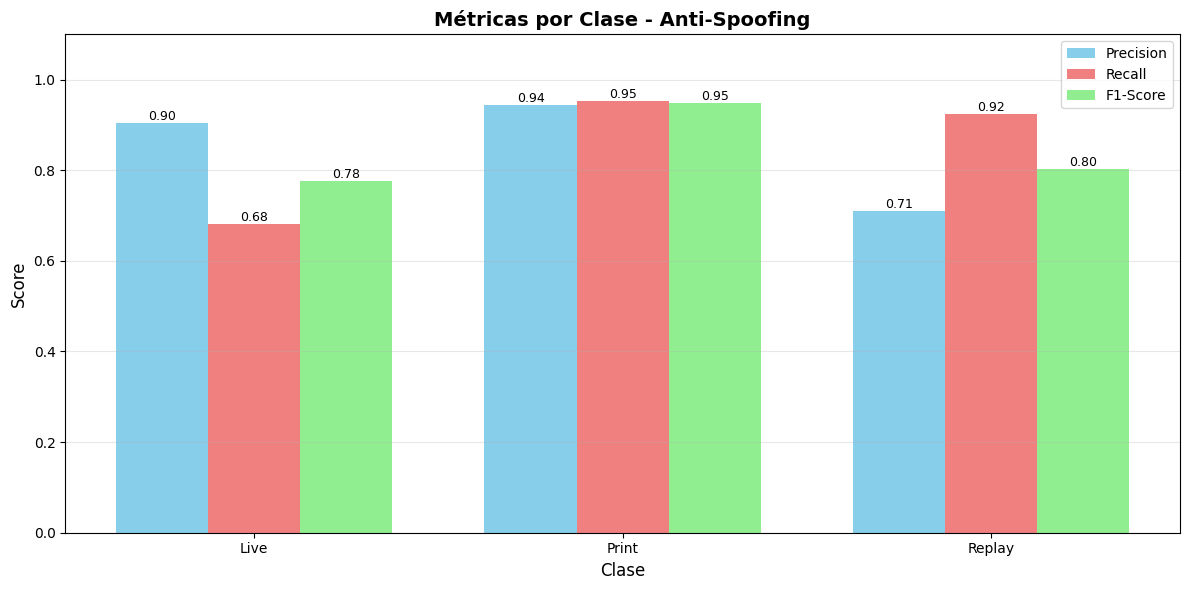

✅ Gráfica de métricas por clase guardada

📊 RESUMEN DE RESULTADOS
Accuracy General: 86.40%

Por Clase:
  Live     - Precision: 90.38% | Recall: 68.12% | F1: 77.69%
  Print    - Precision: 94.39% | Recall: 95.28% | F1: 94.84%
  Replay   - Precision: 71.01% | Recall: 92.45% | F1: 80.33%

=== Visual Evaluation on Test Set Samples ===

Sample 1:
Image Path: extracted_frames/extracted_frames/live_video/9_30.jpg
Description: An image from the 'live' category.
Predicted: live (Not Spoofing)
Actual: live (Not Spoofing)


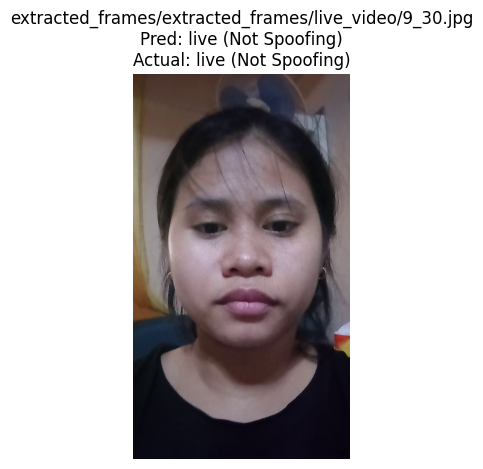


Sample 2:
Image Path: extracted_frames/extracted_frames/printouts/35_40.jpg
Description: An image from the 'print' category.
Predicted: print (Spoofing)
Actual: print (Spoofing)


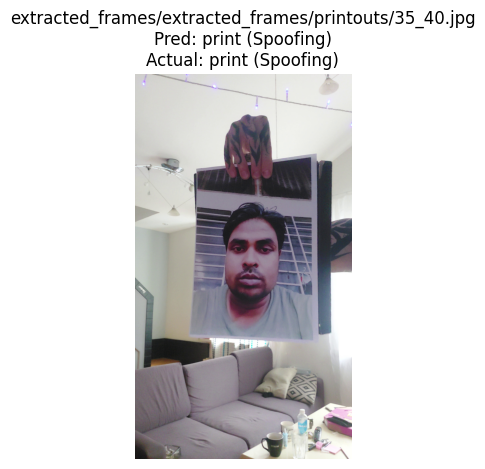


Sample 3:
Image Path: extracted_frames/extracted_frames/replay/43_280.jpg
Description: An image from the 'replay' category.
Predicted: print (Spoofing)
Actual: replay (Spoofing)


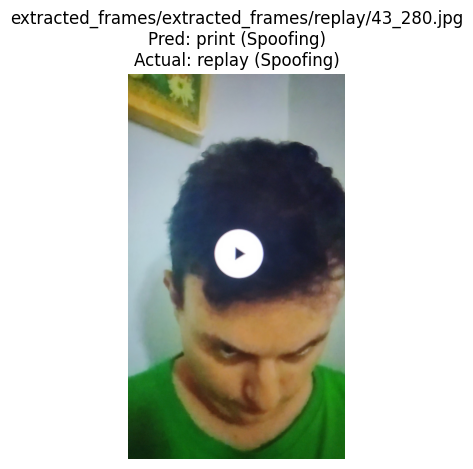

In [2]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ----------------------------
# GPU Configuration
# ----------------------------
print("🔍 Verificando disponibilidad de GPU...")
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print(f"✅ GPU disponible: {torch.cuda.get_device_name(0)}")
    print(f"   Memoria total: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    print(f"   Versión CUDA: {torch.version.cuda}")
    # Configuración para mejor rendimiento en GPU
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True
else:
    device = torch.device("cpu")
    print("⚠️ GPU no disponible, usando CPU")
    print("   Tip: Para usar GPU, asegúrate de tener PyTorch con CUDA instalado")

# ----------------------------
# Paths & read CSV
# ----------------------------
data_dir = 'anti-spoofing'
csv_file = 'anti-spoofing/anti-spoofing.csv'
output_dir = 'extracted_frames'
frames_dir = os.path.join(output_dir, 'extracted_frames')
os.makedirs(frames_dir, exist_ok=True)

try:
    df = pd.read_csv(csv_file, encoding='utf-8')
except FileNotFoundError:
    print(f"CSV file not found at {csv_file}. Please check the file path and ensure the dataset is attached.")
    raise
except UnicodeDecodeError:
    print("UTF-8 encoding failed. Trying 'latin1' encoding...")
    df = pd.read_csv(csv_file, encoding='latin1')

print("Original CSV Columns:", df.columns.tolist())

# Reshape
df_melted = pd.melt(df, var_name='category', value_name='image_path')
df_melted = df_melted.dropna(subset=['image_path'])
print("\nReshaped DataFrame (before processing):")

# Fix extension (image categories -> convert .mp4 -> .jpg)
image_categories = ['live_selfie']
video_categories = ['live_video', 'cut-out_printouts', 'printouts', 'replay']

def fix_extension(row):
    path = str(row['image_path']).strip()
    if row['category'] in image_categories:
        return path.replace('.mp4', '.jpg')
    return path

df_melted['image_path'] = df_melted.apply(fix_extension, axis=1)

# Extract frames
video_extensions = ('.mp4', '.avi', '.mov')
frame_paths = []

for idx, row in df_melted[df_melted['category'].isin(video_categories)].iterrows():
    file_path = os.path.join(data_dir, row['image_path'])
    category = row['category']

    if not file_path.lower().endswith(video_extensions):
        continue

    category_frames_dir = os.path.join(frames_dir, category)
    os.makedirs(category_frames_dir, exist_ok=True)

    cap = cv2.VideoCapture(file_path)
    if not cap.isOpened():
        print(f"Could not open video file: {file_path}")
        continue

    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % 10 == 0:
            frame_filename = f"{idx}_{frame_count}.jpg"
            frame_path = os.path.join(category_frames_dir, frame_filename)
            cv2.imwrite(frame_path, frame)
            relative_frame_path = os.path.join(category, frame_filename)
            frame_paths.append({'category': category, 'image_path': relative_frame_path})

        frame_count += 1

    cap.release()

df_frames = pd.DataFrame(frame_paths)
print(f"Number of extracted frames: {len(df_frames)}")
print("\nDataFrame with extracted frames:")

# Combine images and frames
df_images = df_melted[df_melted['category'].isin(image_categories)][['category', 'image_path']]
if not df_frames.empty:
    df_final = pd.concat([df_images, df_frames], ignore_index=True)
else:
    df_final = df_images

print(f"Total number of entries in final DataFrame: {len(df_final)}")
print("\nFinal DataFrame:")

# Label mapping
label_mapping = {
    'live_selfie': 0,
    'live_video': 0,
    'cut-out_printouts': 1,
    'printouts': 1,
    'replay': 2
}

# ----------------------------
# Custom ResNet-18 implementation (BasicBlock)
# ----------------------------
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet18_Custom(nn.Module):
    def __init__(self, block=BasicBlock, layers=[2,2,2,2], num_classes=3):
        super(ResNet18_Custom, self).__init__()
        self.in_planes = 64
        # initial conv
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # layers
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # init weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_planes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.in_planes, planes, stride, downsample))
        self.in_planes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_planes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)   # [B,64,H/2,W/2]
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x) # [B,64,H/4,W/4]

        x = self.layer1(x)  # [B,64,...]
        x = self.layer2(x)  # [B,128,...]
        x = self.layer3(x)  # [B,256,...]
        x = self.layer4(x)  # [B,512,...]

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

# ----------------------------
# Dataset
# ----------------------------
class AntiSpoofDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.copy().reset_index(drop=True)
        self.transform = transform

        # root_dir
        self.dataframe['root_dir'] = self.dataframe['category'].apply(
            lambda x: data_dir if x in image_categories else frames_dir
        )

        required_columns = ['image_path', 'category', 'root_dir']
        for col in required_columns:
            if col not in self.dataframe.columns:
                raise ValueError(f"Required column '{col}' not found. Available columns: {self.dataframe.columns.tolist()}")

        # filter long paths
        self.dataframe['path_length'] = self.dataframe.apply(
            lambda row: len(os.path.join(row['root_dir'], row['image_path'])), axis=1
        )
        max_path_length = 255
        self.dataframe = self.dataframe[self.dataframe['path_length'] <= max_path_length].drop(columns=['path_length'])
        print(f"Number of entries after filtering long paths: {len(self.dataframe)}")

        if len(self.dataframe) == 0:
            raise ValueError("No valid entries remain after filtering. Check dataset and paths.")

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        root_dir = self.dataframe.iloc[idx]['root_dir']
        rel_path = self.dataframe.iloc[idx]['image_path']
        img_path = os.path.join(root_dir, rel_path)

        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image at {img_path}: {e}")
            raise

        category = self.dataframe.iloc[idx]['category']
        if category not in label_mapping:
            raise ValueError(f"Category '{category}' not in label_mapping")

        label = label_mapping[category]

        if self.transform:
            image = self.transform(image)

        return image, label, img_path

# ----------------------------
# ⚡ DATA AUGMENTATION MEJORADO
# ----------------------------
print("\n🎨 Configurando Data Augmentation...")

# Transforms para ENTRENAMIENTO con augmentation agresivo
train_transforms = transforms.Compose([
    transforms.Resize((240, 240)),  # Resize ligeramente más grande para tener margen
    
    # ====== AUGMENTACIONES CRÍTICAS PARA ANTI-SPOOFING ======
    
    # 1. ROTACIONES ALEATORIAS (simula cámara inclinada)
    transforms.RandomRotation(
        degrees=45,  # ±45 grados (crítico para detección lateral)
        interpolation=transforms.InterpolationMode.BILINEAR,
        fill=0
    ),
    
    # 2. CAMBIOS DE PERSPECTIVA (simula diferentes ángulos)
    transforms.RandomPerspective(
        distortion_scale=0.3,  # 30% de distorsión
        p=0.5
    ),
    
    # 3. CROP ALEATORIO (simula encuadre variable)
    transforms.RandomResizedCrop(
        224, 
        scale=(0.7, 1.0),  # 70%-100% del tamaño original
        ratio=(0.8, 1.2)   # Permite aspect ratio variable
    ),
    
    # 4. FLIP HORIZONTAL (espejado)
    transforms.RandomHorizontalFlip(p=0.5),
    
    # 5. AJUSTES DE COLOR (simula diferentes iluminaciones)
    transforms.ColorJitter(
        brightness=0.3,    # ±30% brillo
        contrast=0.3,      # ±30% contraste
        saturation=0.2,    # ±20% saturación
        hue=0.1           # ±10% tono
    ),
    
    # 6. DESENFOQUE ALEATORIO (simula movimiento/cámara mala)
    transforms.GaussianBlur(
        kernel_size=5,
        sigma=(0.1, 2.0)
    ),
    
    transforms.ToTensor(),
    
    # 7. NORMALIZACIÓN IMAGENET (estándar)
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Transforms para TESTING/VALIDACIÓN (sin augmentation)
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

print("✅ Augmentations configurados:")
print("   - Rotación: ±45°")
print("   - Perspectiva: 30%")
print("   - Crop aleatorio: 70-100%")
print("   - Flip horizontal: 50%")
print("   - Color jitter: brightness/contrast/sat/hue")
print("   - Gaussian blur")

# ----------------------------
# Crear datasets con transforms separados
# ----------------------------
# Primero creamos el dataset completo
full_dataset = AntiSpoofDataset(df_final, transform=None)  # Sin transform aún

# Split
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
if train_size == 0 or test_size == 0:
    raise ValueError(f"Dataset too small to split. Total size: {len(full_dataset)}")

# Separar índices
train_indices, test_indices = torch.utils.data.random_split(
    range(len(full_dataset)), 
    [train_size, test_size]
)

# Crear subsets con transforms diferentes
class TransformSubset(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform
        
    def __len__(self):
        return len(self.subset)
    
    def __getitem__(self, idx):
        # Obtener data original del subset
        original_idx = self.subset.indices[idx]
        root_dir = self.subset.dataset.dataframe.iloc[original_idx]['root_dir']
        rel_path = self.subset.dataset.dataframe.iloc[original_idx]['image_path']
        img_path = os.path.join(root_dir, rel_path)
        category = self.subset.dataset.dataframe.iloc[original_idx]['category']
        label = label_mapping[category]
        
        # Cargar imagen
        image = Image.open(img_path).convert('RGB')
        
        # Aplicar transform
        if self.transform:
            image = self.transform(image)
        
        return image, label, img_path

# Crear splits
base_train_split, base_test_split = torch.utils.data.random_split(
    full_dataset, 
    [train_size, test_size]
)

# Aplicar transforms
train_dataset = TransformSubset(base_train_split, train_transforms)
test_dataset = TransformSubset(base_test_split, test_transforms)

# DataLoader optimizado para GPU
num_workers = 4 if torch.cuda.is_available() else 2
batch_size = 32 if torch.cuda.is_available() else 16

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=num_workers,
    pin_memory=True if torch.cuda.is_available() else False,
    persistent_workers=True if num_workers > 0 else False
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=num_workers,
    pin_memory=True if torch.cuda.is_available() else False,
    persistent_workers=True if num_workers > 0 else False
)

print(f"\n📊 Configuración de entrenamiento:")
print(f"   Dispositivo: {device}")
print(f"   Batch size: {batch_size}")
print(f"   Num workers: {num_workers}")
print(f"   Train samples: {len(train_dataset)}")
print(f"   Test samples: {len(test_dataset)}")

# ----------------------------
# Instantiate custom ResNet18
# ----------------------------
model = ResNet18_Custom(num_classes=3).to(device)
print(f"✅ Modelo cargado en {device}")

# ----------------------------
# Loss + Optimizer with class weights
# ----------------------------
# compute class counts from train split
train_labels = []
for idx in base_train_split.indices:
    category = full_dataset.dataframe.iloc[idx]['category']
    train_labels.append(label_mapping[category])

class_counts = [0] * 3
for lbl in train_labels:
    class_counts[lbl] += 1

# avoid zero division
class_weights = torch.tensor([1.0 / (c + 1e-6) for c in class_counts], device=device)
class_weights = class_weights / class_weights.sum() * len(class_counts)
print(f"Class weights: {class_weights}")

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# ----------------------------
# Training loop con métricas guardadas
# ----------------------------
num_epochs = 30
print(f"\n🚀 Iniciando entrenamiento por {num_epochs} épocas con DATA AUGMENTATION...\n")

# Listas para guardar métricas
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels, _ in train_loader:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        running_loss += loss.item() * images.size(0)

    scheduler.step()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct / total if total > 0 else 0.0
    
    # Guardar métricas
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Train Acc: {epoch_acc:.4f}")

    # save checkpoint
    checkpoint_path = os.path.join(output_dir, f'model_checkpoint_epoch_{epoch+1}.pth')
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': epoch_loss,
    }, checkpoint_path)
    print(f"Saved checkpoint: {checkpoint_path}")

# Save final model weights (state_dict)
final_model_path = os.path.join(output_dir, 'final_resnet18_custom.pth')
torch.save(model.state_dict(), final_model_path)
print(f"✅ Final model saved at {final_model_path}")

# ----------------------------
# Evaluation
# ----------------------------
print(f"\n📊 Evaluando modelo en set de prueba...")
model.eval()
all_preds = []
all_labels = []
misclassified = []

with torch.no_grad():
    for batch_idx, (images, labels, _) in enumerate(test_loader):
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy().tolist())
        all_labels.extend(labels.cpu().numpy().tolist())

        for i in range(len(labels)):
            if preds[i] != labels[i]:
                misclassified.append({
                    'true_label': labels[i].cpu().item(),
                    'pred_label': preds[i].cpu().item(),
                    'batch_idx': batch_idx,
                    'sample_idx': i
                })

print(f"\nNumber of misclassified samples: {len(misclassified)}")
for mis in misclassified[:50]:
    print(f"Batch {mis['batch_idx']}, idx {mis['sample_idx']}: true {mis['true_label']}, pred {mis['pred_label']}")

report = classification_report(all_labels, all_preds, target_names=['live', 'print', 'replay'], output_dict=True)
print("\nClassification Report:")
for label, metrics in report.items():
    if label in ['live', 'print', 'replay']:
        print(f"{label:>10}  {metrics['precision']:.2f}  {metrics['recall']:.2f}  {metrics['f1-score']:.2f}  {int(metrics['support'])}")
    elif label == 'accuracy':
        print(f"\n{label:>10}  {metrics:.2f}")

# ----------------------------
# 📊 VISUALIZACIONES
# ----------------------------
class_names = ['live', 'print', 'replay']

print("\n📊 Generando visualizaciones...")

# 1. CURVAS DE ENTRENAMIENTO
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(range(1, num_epochs+1), train_losses, 'b-', linewidth=2, marker='o')
axes[0].set_xlabel('Época', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Pérdida durante Entrenamiento', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(range(1, num_epochs+1), train_accuracies, 'g-', linewidth=2, marker='o')
axes[1].set_xlabel('Época', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Precisión durante Entrenamiento', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'training_curves.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfica de curvas de entrenamiento guardada")

# 2. MATRIZ DE CONFUSIÓN
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Cantidad'})
plt.title('Matriz de Confusión - Anti-Spoofing', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Etiqueta Real', fontsize=12)
plt.xlabel('Predicción', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✅ Matriz de confusión guardada")

# 3. MATRIZ DE CONFUSIÓN NORMALIZADA (por fila)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='RdYlGn', 
            xticklabels=class_names, yticklabels=class_names,
            vmin=0, vmax=1, cbar_kws={'label': 'Porcentaje'})
plt.title('Matriz de Confusión Normalizada - Anti-Spoofing', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Etiqueta Real', fontsize=12)
plt.xlabel('Predicción', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'confusion_matrix_normalized.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✅ Matriz de confusión normalizada guardada")

# 4. MÉTRICAS POR CLASE (Bar Chart)
metrics_data = {
    'Class': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': []
}

for label in ['live', 'print', 'replay']:
    metrics_data['Class'].append(label.capitalize())
    metrics_data['Precision'].append(report[label]['precision'])
    metrics_data['Recall'].append(report[label]['recall'])
    metrics_data['F1-Score'].append(report[label]['f1-score'])

x = np.arange(len(metrics_data['Class']))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width, metrics_data['Precision'], width, label='Precision', color='skyblue')
bars2 = ax.bar(x, metrics_data['Recall'], width, label='Recall', color='lightcoral')
bars3 = ax.bar(x + width, metrics_data['F1-Score'], width, label='F1-Score', color='lightgreen')

ax.set_xlabel('Clase', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Métricas por Clase - Anti-Spoofing', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_data['Class'])
ax.legend()
ax.set_ylim([0, 1.1])
ax.grid(True, alpha=0.3, axis='y')

# Agregar valores encima de las barras
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'metrics_per_class.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfica de métricas por clase guardada")

# 5. RESUMEN DE RESULTADOS
print("\n" + "="*60)
print("📊 RESUMEN DE RESULTADOS")
print("="*60)
print(f"Accuracy General: {report['accuracy']:.2%}")
print(f"\nPor Clase:")
for label in ['live', 'print', 'replay']:
    print(f"  {label.capitalize():8} - Precision: {report[label]['precision']:.2%} | "
          f"Recall: {report[label]['recall']:.2%} | F1: {report[label]['f1-score']:.2%}")
print("="*60)

# ----------------------------
# Visual evaluation helpers
# ----------------------------
def predict_image(image_path, model, transform, device):
    model.eval()
    img = Image.open(image_path).convert('RGB')
    img_t = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(img_t)
        _, p = torch.max(out, 1)
    return p.item()

def is_spoofing(label_name):
    return "Spoofing" if label_name in ['print', 'replay'] else "Not Spoofing"

def display_image(image_path, predicted_label, actual_label):
    img = Image.open(image_path)
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.title(f"{image_path}\nPred: {predicted_label} ({is_spoofing(predicted_label)})\nActual: {actual_label} ({is_spoofing(actual_label)})")
    plt.axis('off')
    plt.show()

# Collect one sample per class from test set
selected_samples = {0: None, 1: None, 2: None}
for images, labels, img_paths in test_loader:
    for i in range(len(labels)):
        lbl = labels[i].item()
        if selected_samples[lbl] is None:
            selected_samples[lbl] = {'image_path': img_paths[i], 'label': lbl}
    if all(v is not None for v in selected_samples.values()):
        break

samples_to_evaluate = [v for k,v in sorted(selected_samples.items()) if v is not None]

print("\n=== Visual Evaluation on Test Set Samples ===")
for idx, sample in enumerate(samples_to_evaluate):
    image_path = sample['image_path']
    actual_label = class_names[sample['label']]
    prediction_idx = predict_image(image_path, model, test_transforms, device)
    predicted_label = class_names[prediction_idx]

    print(f"\nSample {idx+1}:")
    print(f"Image Path: {image_path}")
    print(f"Description: An image from the '{actual_label}' category.")
    print(f"Predicted: {predicted_label} ({is_spoofing(predicted_label)})")
    print(f"Actual: {actual_label} ({is_spoofing(actual_label)})")

    display_image(image_path, predicted_label, actual_label)
